### 1 确认模型已经下载OK

代码改造自 udacity迁移学习，这里只包含一个ipython文件，其他的使用uda的即可

需要下载 vgg16

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. Make sure to clone this repository to the directory you're working from. You'll also want to rename it so it has an underscore instead of a dash.

```
git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
```

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

In [1]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

from jpg_data_preprocess import *

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',

            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


### 2 图像路径获取

读取类别，子路径获取

In [2]:
def read_pic_path(data_dir):
    contents = os.listdir(data_dir)
    classes = [each for each in contents if os.path.isdir(data_dir + each)]
    return classes

train_dir = 'pig_pic_src_processed_2/train/'
valid_dir = 'pig_pic_src_processed_2/valid/'

# 将目录名称变换为名称的list
train_classes = read_pic_path(train_dir)
print(train_classes)

valid_classes = read_pic_path(valid_dir)
print(valid_classes)

['01.pig', '02.pig', '03.pig', '04.pig', '05.pig', '06.pig', '07.pig', '08.pig', '09.pig', '10.pig', '11.pig', '12.pig', '13.pig', '14.pig', '15.pig', '16.pig', '17.pig', '18.pig', '19.pig', '20.pig', '21.pig', '22.pig', '23.pig', '24.pig', '25.pig', '26.pig', '27.pig', '28.pig', '29.pig', '30.pig']
['01.pig', '02.pig', '03.pig', '04.pig', '05.pig', '06.pig', '07.pig', '08.pig', '09.pig', '10.pig', '11.pig', '12.pig', '13.pig', '14.pig', '15.pig', '16.pig', '17.pig', '18.pig', '19.pig', '20.pig', '21.pig', '22.pig', '23.pig', '24.pig', '25.pig', '26.pig', '27.pig', '28.pig', '29.pig', '30.pig']


### 3 构建迁移模型运行方式

运行迁移模型，获得 code

In [3]:
# Set the batch size higher if you can fit in in your GPU memory
def run_transfer_model(data_dir, classes, batch_size = 10):
    codes_list = []
    labels = []
    batch = []
    codes = None
    
#    fix_gpu_error()
    
    tf.reset_default_graph()

    with tf.Session() as sess:
        # TODO: Build the vgg network here
        if 'vgg' in globals():
            print('"vgg" object already exists.  Will not create again.')
        else:
        #create vgg
            vgg = vgg16.Vgg16()
            input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
            with tf.name_scope("content_vgg"):
                vgg.build(input_)

        for each in classes:
            print("Starting {} images".format(each))
            class_path = data_dir + each
            # 列出所有的文件名称
            files = os.listdir(class_path)
            for ii, file in enumerate(files, 1):
                # Add images to the current batch
                # utils.load_image crops the input images for us, from the center
            
                # 每次添加一张图片
                img = utils.load_image(os.path.join(class_path, file))
                
                # 每次处理一张图片                
                batch.append(img.reshape((1, 224, 224, 3)))                
                # 每次添加一个labels
                labels.append(each)              

                # Running the batch through the network to get the codes
                if ii % batch_size == 0 or ii == len(files):
                
                    # Image batch to pass to VGG network
                    images = np.concatenate(batch)
                    # TODO: Get the values from the relu6 layer of the VGG network
                    feed_dict = {input_: images}                    
                    codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                    # Here I'm building an array of the codes
                    if codes is None:
                        codes = codes_batch
                    else:
                        codes = np.concatenate((codes, codes_batch))
                
                    print(codes.shape)
                
                    # Reset to start building the next batch
                    batch = []
                    print('{} images processed'.format(ii))
    return codes, labels

运行构建好的迁移模型，获得 cnn code

In [4]:
train_codes, train_labels = run_transfer_model(train_dir, train_classes, batch_size = 48)
valid_codes, valid_labels = run_transfer_model(valid_dir, train_classes, batch_size = 48)

E:\PROJECT\Competition\vgg-base\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting 01.pig images
(48, 4096)
48 images processed
(96, 4096)
96 images processed
(144, 4096)
144 images processed
(192, 4096)
192 images processed
(240, 4096)
240 images processed
(288, 4096)
288 images processed
(336, 4096)
336 images processed
(384, 4096)
384 images processed
(432, 4096)
432 images processed
(480, 4096)
480 images processed
(528, 4096)
528 images processed
(576, 4096)
576 images processed
(624, 4096)
624 images processed
(672, 4096)
672 images processed
(720, 4096)
720 images processed
(768, 4096)
768 images processed
(816, 4096)
816 images processed
(864, 4096)
864 images processed
(912, 4096)
912 images processed
(960, 4096)
960 images processed
(980, 4096)
980 images processed
Starting 02.pig images
(1028, 4096)
48 images processed
(1076, 4096)
96 images processed
(1124, 4096)
144 images processed
(1172, 4096)
192 images processed
(1220, 4096)


1392 images processed
(10970, 4096)
1440 images processed
(11018, 4096)
1488 images processed
(11066, 4096)
1536 images processed
(11114, 4096)
1584 images processed
(11162, 4096)
1632 images processed
(11210, 4096)
1680 images processed
(11258, 4096)
1728 images processed
(11306, 4096)
1776 images processed
(11320, 4096)
1790 images processed
Starting 09.pig images
(11368, 4096)
48 images processed
(11416, 4096)
96 images processed
(11464, 4096)
144 images processed
(11512, 4096)
192 images processed
(11560, 4096)
240 images processed
(11608, 4096)
288 images processed
(11656, 4096)
336 images processed
(11704, 4096)
384 images processed
(11752, 4096)
432 images processed
(11800, 4096)
480 images processed
(11848, 4096)
528 images processed
(11896, 4096)
576 images processed
(11944, 4096)
624 images processed
(11992, 4096)
672 images processed
(12040, 4096)
720 images processed
(12088, 4096)
768 images processed
(12136, 4096)
816 images processed
(12184, 4096)
864 images processed
(12

672 images processed
(21660, 4096)
720 images processed
(21708, 4096)
768 images processed
(21756, 4096)
816 images processed
(21804, 4096)
864 images processed
(21852, 4096)
912 images processed
(21900, 4096)
960 images processed
(21948, 4096)
1008 images processed
(21996, 4096)
1056 images processed
(22044, 4096)
1104 images processed
(22092, 4096)
1152 images processed
(22140, 4096)
1200 images processed
(22188, 4096)
1248 images processed
(22236, 4096)
1296 images processed
(22284, 4096)
1344 images processed
(22332, 4096)
1392 images processed
(22380, 4096)
1440 images processed
(22428, 4096)
1488 images processed
(22476, 4096)
1536 images processed
(22524, 4096)
1584 images processed
(22572, 4096)
1632 images processed
(22610, 4096)
1670 images processed
Starting 16.pig images
(22658, 4096)
48 images processed
(22706, 4096)
96 images processed
(22754, 4096)
144 images processed
(22802, 4096)
192 images processed
(22850, 4096)
240 images processed
(22898, 4096)
288 images processe

192 images processed
(32440, 4096)
240 images processed
(32488, 4096)
288 images processed
(32536, 4096)
336 images processed
(32584, 4096)
384 images processed
(32632, 4096)
432 images processed
(32680, 4096)
480 images processed
(32728, 4096)
528 images processed
(32776, 4096)
576 images processed
(32824, 4096)
624 images processed
(32872, 4096)
672 images processed
(32920, 4096)
720 images processed
(32968, 4096)
768 images processed
(33016, 4096)
816 images processed
(33064, 4096)
864 images processed
(33112, 4096)
912 images processed
(33160, 4096)
960 images processed
(33208, 4096)
1008 images processed
(33256, 4096)
1056 images processed
(33304, 4096)
1104 images processed
(33352, 4096)
1152 images processed
(33400, 4096)
1200 images processed
(33448, 4096)
1248 images processed
(33496, 4096)
1296 images processed
(33544, 4096)
1344 images processed
(33592, 4096)
1392 images processed
(33640, 4096)
1440 images processed
(33688, 4096)
1488 images processed
(33736, 4096)
1536 imag

336 images processed
(43154, 4096)
384 images processed
(43202, 4096)
432 images processed
(43250, 4096)
480 images processed
(43298, 4096)
528 images processed
(43346, 4096)
576 images processed
(43394, 4096)
624 images processed
(43442, 4096)
672 images processed
(43490, 4096)
720 images processed
(43538, 4096)
768 images processed
(43586, 4096)
816 images processed
(43634, 4096)
864 images processed
(43682, 4096)
912 images processed
(43730, 4096)
960 images processed
(43778, 4096)
1008 images processed
(43826, 4096)
1056 images processed
(43874, 4096)
1104 images processed
(43922, 4096)
1152 images processed
(43970, 4096)
1200 images processed
(44018, 4096)
1248 images processed
(44066, 4096)
1296 images processed
(44114, 4096)
1344 images processed
(44162, 4096)
1392 images processed
(44210, 4096)
1440 images processed
(44258, 4096)
1488 images processed
(44306, 4096)
1536 images processed
(44354, 4096)
1584 images processed
(44402, 4096)
1632 images processed
(44450, 4096)
1680 i

将cnn code 保存到文件中

In [5]:
import csv

def save2file(codes_file, codes_name, labels_file, labels_name):
    # write codes to file
    with open(codes_name, 'w') as f:
        codes_file.tofile(f)

    # write labels to file    
    with open(labels_name, 'w') as f:
        writer = csv.writer(f, delimiter='\n')
        writer.writerow(labels_file)

save2file(train_codes, 'train_codes', train_labels, 'train_labels')
save2file(valid_codes, 'valid_codes', valid_labels, 'valid_labels')

### 4 检查点

已经保存好的模型，可以从这里开始运行

In [6]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

# tensorflow gpu error
def fix_gpu_error():
    if 'session' in locals() and session is not None:
        print('Close interactive session')
        session.close()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

读取cnn code

In [7]:
# read codes and labels from file
import csv

def read_from_file(codes_name, labels_name):
    with open(labels_name) as f:
        reader = csv.reader(f, delimiter='\n')
        labels = np.array([each for each in reader if len(each) > 0]).squeeze()
    with open(codes_name) as f:
        codes = np.fromfile(f, dtype=np.float32)
        codes = codes.reshape((len(labels), -1))
        print(len(labels))
    return codes, labels

train_codes, train_labels = read_from_file('train_codes', 'train_labels')
valid_codes, valid_labels = read_from_file('valid_codes', 'valid_labels')
print(train_codes.shape)

49360
119
(49360, 4096)


### 5 分类器之前的数据处理 

独热编码

In [8]:
from sklearn.preprocessing import LabelBinarizer

def one_hot_encode(labels):
    lb = LabelBinarizer()
    lb.fit(labels)
    return lb.transform(labels)

train_labels_vecs = one_hot_encode(train_labels)
valid_labels_vecs = one_hot_encode(valid_labels)



lb = LabelBinarizer()
lb.fit(train_labels)
lb.transform(train_labels)

print(valid_labels_vecs.shape)
print(train_labels_vecs.shape)

(119, 30)
(49360, 30)


随机化数据，分train和test，valid

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.01)

train_idx, test_idx = next(ss.split(train_codes, train_labels))

train_x, train_y = train_codes[train_idx], train_labels_vecs[train_idx]
test_x, test_y = train_codes[test_idx], train_labels_vecs[test_idx]
val_x, val_y = valid_codes, valid_labels_vecs

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)

(48866, 4096)
(494, 4096)
(119, 4096)


### 6 分类器构建

In [10]:
inputs_ = tf.placeholder(tf.float32, shape=[None, train_x.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, train_y.shape[1]])


# default use ReLU activation func
fc = tf.contrib.layers.fully_connected(inputs_, 1024)
tf.nn.dropout(fc, 0.5)
fc = tf.contrib.layers.fully_connected(fc, 256)
tf.nn.dropout(fc, 0.5)

# output, none activation func
logits = tf.contrib.layers.fully_connected(fc, train_y.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [11]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

In [15]:
epochs = 15
batches = 10
iteration = 0

saver = tf.train.Saver()

with tf.Session() as sess:
    fix_gpu_error()
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y, batches):
        #for x, y in get_batches(train_np_x, train_np_y, batches):
            feed = {inputs_: x,
                    labels_: y}
            train_acc, loss, _ = sess.run([accuracy, cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training Acc: {:.5f}".format(train_acc),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                loss = sess.run(cost, feed_dict=feed)
                print("\n")
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc),
                      "Validation Loss: {:.4f}".format(loss))
    saver.save(sess, "checkpoints/pig.ckpt")

Epoch: 1/15 Iteration: 0 Training Acc: 0.04257 Training loss: 9.34437
Epoch: 1/15 Iteration: 1 Training Acc: 0.02702 Training loss: 23.89342
Epoch: 1/15 Iteration: 2 Training Acc: 0.07716 Training loss: 17.44601
Epoch: 1/15 Iteration: 3 Training Acc: 0.07184 Training loss: 17.97209
Epoch: 1/15 Iteration: 4 Training Acc: 0.08596 Training loss: 17.78444


Epoch: 0/15 Iteration: 5 Validation Acc: 0.0756 Validation Loss: 15.4180
Epoch: 1/15 Iteration: 5 Training Acc: 0.09763 Training loss: 14.88700
Epoch: 1/15 Iteration: 6 Training Acc: 0.16844 Training loss: 14.24618
Epoch: 1/15 Iteration: 7 Training Acc: 0.17049 Training loss: 13.07478
Epoch: 1/15 Iteration: 8 Training Acc: 0.19709 Training loss: 11.54048
Epoch: 1/15 Iteration: 9 Training Acc: 0.17069 Training loss: 11.57318


Epoch: 0/15 Iteration: 10 Validation Acc: 0.0924 Validation Loss: 10.6546
Epoch: 2/15 Iteration: 10 Training Acc: 0.19095 Training loss: 10.45749
Epoch: 2/15 Iteration: 11 Training Acc: 0.23086 Training loss: 8.469

Epoch: 10/15 Iteration: 95 Training Acc: 0.95559 Training loss: 0.19023
Epoch: 10/15 Iteration: 96 Training Acc: 0.96296 Training loss: 0.17061
Epoch: 10/15 Iteration: 97 Training Acc: 0.96398 Training loss: 0.16990
Epoch: 10/15 Iteration: 98 Training Acc: 0.96336 Training loss: 0.17062
Epoch: 10/15 Iteration: 99 Training Acc: 0.95912 Training loss: 0.17951


Epoch: 9/15 Iteration: 100 Validation Acc: 0.4958 Validation Loss: 1.8133
Epoch: 11/15 Iteration: 100 Training Acc: 0.96746 Training loss: 0.15917
Epoch: 11/15 Iteration: 101 Training Acc: 0.96500 Training loss: 0.16237
Epoch: 11/15 Iteration: 102 Training Acc: 0.96991 Training loss: 0.15082
Epoch: 11/15 Iteration: 103 Training Acc: 0.97012 Training loss: 0.14844
Epoch: 11/15 Iteration: 104 Training Acc: 0.96869 Training loss: 0.14147


Epoch: 10/15 Iteration: 105 Validation Acc: 0.4958 Validation Loss: 1.7978
Epoch: 11/15 Iteration: 105 Training Acc: 0.96684 Training loss: 0.14795
Epoch: 11/15 Iteration: 106 Training Acc: 0.97319

### 检查点2
仅仅验证的话， 从这里开始即可

In [16]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: val_x,
            labels_: val_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    test_loss = sess.run(cost, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))
    print("Test loss: {:.4f}".format(test_loss))

INFO:tensorflow:Restoring parameters from checkpoints\pig.ckpt
Test accuracy: 0.5294
Test loss: 1.6894


In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

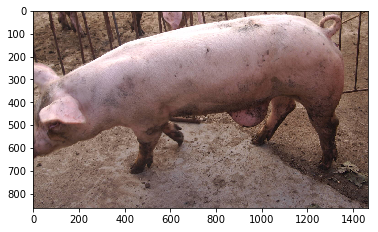

In [19]:
#test_img_path = 'test_A/8.JPG'  #6
#test_img_path = 'test_A/70.JPG' #8
test_img_path = 'test_A/10.JPG'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [20]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        input_ = tf.clip_by_value(input_, 0.0, 1.0)
        vgg = vgg16.Vgg16()
        vgg.build(input_)

E:\PROJECT\Competition\vgg-base\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s


In [21]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints\pig.ckpt


[  9.03545006e-05   3.75671941e-03   1.18599542e-04   3.55061522e-04
   3.31121691e-06   2.69817392e-04   1.27225751e-02   9.10627365e-01
   6.73755585e-06   3.13561759e-05   1.07757105e-02   6.96701536e-05
   1.85596175e-04   3.46418377e-03   2.29504425e-03   4.10550492e-05
   1.55861664e-03   7.02700752e-04   1.50048602e-02   2.95974321e-08
   8.32772457e-06   2.79633980e-02   9.46471002e-04   9.88367174e-05
   5.29247057e-03   1.08741596e-03   2.27464340e-03   2.26963675e-04
   1.94227396e-05   2.65887434e-06]


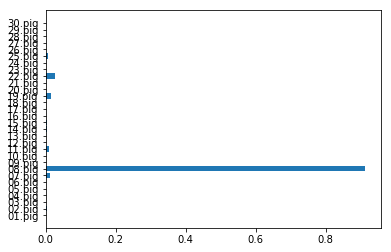

In [22]:
print(prediction)
plt.barh(np.arange(30), prediction)
_ = plt.yticks(np.arange(30), lb.classes_)

# 输出A榜结果

In [23]:
def read_pic_name(data_dir):
    contents = os.listdir(data_dir)
    return contents

testA_dir = 'test_A/'

# 将目录名称变换为名称的list
testA_files = read_pic_name(testA_dir)
print(testA_files)

['10.JPG', '100.JPG', '1000.JPG', '1001.JPG', '1004.JPG', '1005.JPG', '1006.JPG', '1007.JPG', '1009.JPG', '1012.JPG', '1013.JPG', '1014.JPG', '1017.JPG', '1019.JPG', '1020.JPG', '1021.JPG', '1024.JPG', '1025.JPG', '1027.JPG', '1029.JPG', '103.JPG', '1030.JPG', '1033.JPG', '1034.JPG', '1035.JPG', '1037.JPG', '1039.JPG', '104.JPG', '1044.JPG', '1046.JPG', '1048.JPG', '1049.JPG', '1050.JPG', '1056.JPG', '1058.JPG', '1059.JPG', '106.JPG', '1060.JPG', '1062.JPG', '1063.JPG', '1064.JPG', '1070.JPG', '1073.JPG', '1074.JPG', '1075.JPG', '1077.JPG', '1078.JPG', '1079.JPG', '1080.JPG', '1084.JPG', '1085.JPG', '1086.JPG', '1087.JPG', '1088.JPG', '1091.JPG', '1092.JPG', '1093.JPG', '1095.JPG', '1096.JPG', '1097.JPG', '1100.JPG', '1102.JPG', '1104.JPG', '1105.JPG', '1106.JPG', '1112.JPG', '1113.JPG', '1115.JPG', '1116.JPG', '1119.JPG', '1121.JPG', '1122.JPG', '1128.JPG', '1129.JPG', '113.JPG', '1131.JPG', '1136.JPG', '1138.JPG', '1139.JPG', '114.JPG', '1141.JPG', '1142.JPG', '1145.JPG', '1146.JPG',

In [24]:
saver = tf.train.Saver()

if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

def processed_img_with_vgg16(files_name_list, files_path, sess, batch_size = 10):
    
    codes_list = []
    batch = []
    codes = None
    
    fix_gpu_error()

    codes = None
    for ii, file in enumerate(testA_files, 1):
        # Add images to the current batch
        # utils.load_image crops the input images for us, from the center
            
        # 每次添加一张图片
        img = utils.load_image(os.path.join(files_path, file))
        # 每次处理一张图片
        batch.append(img.reshape((1, 224, 224, 3)))

        # Running the batch through the network to get the codes
        if ii % batch_size == 0 or ii == len(files_path):
            images = np.concatenate(batch)
            feed_dict = {input_: images}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
        
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
            
            print(codes.shape)
    
            batch = []
            print('{} images processed'.format(ii))
    return codes

with tf.Session() as sess:
    codes = processed_img_with_vgg16(testA_files, testA_dir, sess, batch_size = 10)

"vgg" object already exists.  Will not create again.
(7, 4096)
7 images processed
(10, 4096)
10 images processed
(20, 4096)
20 images processed


KeyboardInterrupt: 

In [25]:
print(len(codes))
print(codes.shape)
with open('testA_codes', 'w') as f:
    codes.tofile(f)

NameError: name 'codes' is not defined

In [25]:
with open('testA_codes') as f:
    testA_codes = np.fromfile(f, dtype=np.float32)
    print(testA_codes.shape)
    testA_codes = testA_codes.reshape((3000, -1))

print(testA_codes.shape)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    feed = {inputs_: testA_codes}
    predictions = sess.run(predicted, feed_dict=feed).squeeze()

(12288000,)
(3000, 4096)
INFO:tensorflow:Restoring parameters from checkpoints\pig.ckpt


In [26]:
print(predictions.shape)
print(max(predictions[0]))

(3000, 30)
0.910628


In [27]:
pic_num = ''
class_num = 0
class_prob = 0

out_put = np.zeros((30*3000, 3))
print(out_put.shape)

import csv  

def as_num(x):
    y = '{:.6f}'.format(x) # 6f表示保留6位小数点的float型
    return(y)

with open('output.csv', 'w+', newline='') as csv_file:  
    writer = csv.writer(csv_file)  
        
    for index, name in enumerate(testA_files):
        pic_num = name.split('.')[0]
        for count, probability in enumerate(predictions[index]):
            class_num = count + 1
            class_prob = as_num(probability)
            writer.writerow([pic_num, str(class_num), str(class_prob)])

(90000, 3)


In [28]:
a = [1,2,3,4,5,6,7,8]
print(a[:2])

[1, 2]
